In [29]:
#initialization
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

lambda_ = 0.05
beta = 0.1
delta_t=0.1
k = 1         
sig=1

M=50
m=4



def s(j,delta_t,s_0):
    mean=s_0 * np.exp(lambda_ * j * delta_t)
    variance=(np.exp(2* lambda_ * j * delta_t) -1)*sig**2/(2*lambda_)
    return np.random.normal(mean,np.sqrt(variance))
    
# Reward function
def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * s * (-3 * k * np.cos(k * s)**2 * np.sin(k * s))
    reward -= (sig**2/2)*(6 * k**2 * np.cos(s) * np.sin(k*s)**2 - 3* k**2 * np.cos(k*s)**3)
    return reward
    
# Define periodic bases
def bases(s):
    bases=[1/np.sqrt(2*np.pi)]
    for m in range(1,M+1):
        bases.append(np.cos(m*s)/np.sqrt(np.pi))
        bases.append(np.sin(m*s)/np.sqrt(np.pi))
    return np.array(bases).reshape(-1,1)   #return column vector

def gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
        gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)  

def gra_gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m**2*np.cos(m*s)/np.sqrt(np.pi))
        gradient_bases.append(-m**2*np.sin(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)







In [30]:

#compute
dataamount = [10,100,600,3000]  # Number of trajectories


error_PhiBE = []
error_BFF = []
error_PhiBE_2nd = []
error_BFF_2nd = []

for i in range(10):
    error_PhiBE.append([])
    error_BFF.append([])
    error_PhiBE_2nd.append([])
    error_BFF_2nd.append([])

# loop through each data amount
for num_trajectories in dataamount:
    
    # generate 10 trials for each num_trajectories
    for trial in range(10):
        s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)
        trajectories = []
        for s_0 in s_0_values:
            traj = [s_0]
            for j in range(m+3):
                s_now = traj[-1]
                s_next = s(1, delta_t, s_now)    
                traj.append(s_next)
            trajectories.append(traj)

        # Algorithm to 1st order PhiBE
        A = np.zeros((2 * M + 1, 2 * M + 1))
        b = np.zeros((2 * M + 1, 1))

        for traj in trajectories:
            for j in range(m):
                s_j = traj[j]
                mu = (traj[j+1]-traj[j]) / delta_t
                sigma = (traj[j+1]-traj[j]) ** 2 / delta_t
                A += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma / 2) * gra_gradient_bases(s_j)).T
                b += reward_function(s_j) * bases(s_j)

        theta = np.linalg.solve(A, b)
        error = 0
        for s_0 in s_0_values:
            V = theta.T @ bases(s_0)
            error += (V - np.cos(k * s_0) ** 3) ** 2 * 2 * np.pi / num_trajectories
        error_PhiBE[trial].append(np.sqrt(error).item())

        # Algorithm to 2nd order PhiBE
        A11 = np.zeros((2 * M + 1, 2 * M + 1))
        b11 = np.zeros((2 * M + 1, 1))

        for traj in trajectories:
            for j in range(m):
                s_j = traj[j]
                mu = (2 * (traj[j+1] - traj[j]) - (1 / 2) * (traj[j+2] - traj[j])) / delta_t
                sigma = 2 * (traj[j+1] - traj[j]) ** 2 - (1 / 2) * (traj[j+2] - traj[j]) ** 2
                sigma = sigma / delta_t
                A11 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma / 2) * gra_gradient_bases(s_j)).T
                b11 += reward_function(s_j) * bases(s_j)

        theta11 = np.linalg.solve(A11, b11)
        error = 0
        for s_0 in s_0_values:
            a = theta11.T @ bases(s_0)
            error += (a - np.cos(k * s_0) ** 3) ** 2 * 2 * np.pi / num_trajectories
        error_PhiBE_2nd[trial].append(np.sqrt(error).item())

        # Algorithm to 1st order BFF
        A2 = np.zeros((2 * M + 1, 2 * M + 1))
        b2 = np.zeros((2 * M + 1, 1))

        for traj in trajectories:
            for j in range(m):
                s_j = traj[j]
                mu = (traj[j+1] - traj[j]) / delta_t
                sigma = (traj[j+1] - traj[j]) ** 2 - (traj[j+2] - traj[j+1]) * (traj[j+1] - traj[j])
                sigma = sigma / delta_t
                A2 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma / 2) * gra_gradient_bases(s_j)).T
                b2 += reward_function(s_j) * bases(s_j)

        theta2 = np.linalg.solve(A2, b2)
        error = 0
        for s_0 in s_0_values:
            V = theta2.T @ bases(s_0)
            error += (V - np.cos(k * s_0) ** 3) ** 2 * 2 * np.pi / num_trajectories
        error_BFF[trial].append(np.sqrt(error).item())

        # Algorithm to 2nd order BFF
        A21 = np.zeros((2 * M + 1, 2 * M + 1))
        b21 = np.zeros((2 * M + 1, 1))

        for traj in trajectories:
            for j in range(m):
                s_j = traj[j]
                mu = (2 * (traj[j+1] - traj[j]) - (1 / 2) * (traj[j+2] - traj[j])) / delta_t
                sigma = 2 * (traj[j+1] - traj[j]) ** 2 - (1 / 2) * (traj[j+2] - traj[j]) ** 2
                sigma -= 2 * (traj[j+2] - traj[j+1]) * (traj[j+1] - traj[j]) - (1 / 2) * (traj[j+1] + traj[j+3] - traj[j+2] - traj[j]) * (traj[j+2] - traj[j])
                sigma = sigma / delta_t
                A21 += bases(s_j) @ (beta * bases(s_j) - mu * gradient_bases(s_j) - (sigma / 2) * gra_gradient_bases(s_j)).T
                b21 += reward_function(s_j) * bases(s_j)

        theta21 = np.linalg.solve(A21, b21)
        error = 0
        for s_0 in s_0_values:
            a = theta21.T @ bases(s_0)
            error += (a - np.cos(k * s_0) ** 3) ** 2 * 2 * np.pi / num_trajectories
        error_BFF_2nd[trial].append(np.sqrt(error).item())


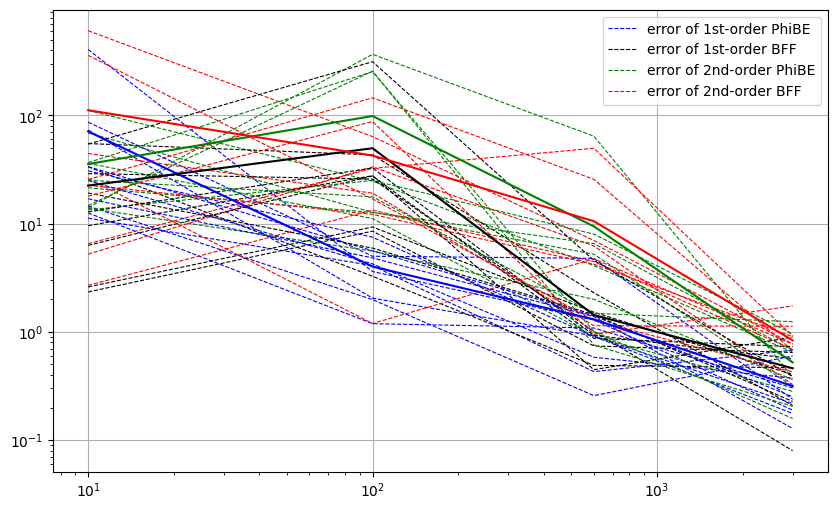

In [32]:

# Plot
plt.figure(figsize=(10, 6))


for i in range(10):
    if i == 0:
        plt.loglog(dataamount, error_PhiBE[i], 'b--', label='error of 1st-order PhiBE', linewidth=0.8)
        plt.loglog(dataamount, error_BFF[i], 'k--', label='error of 1st-order BFF', linewidth=0.8)
        plt.loglog(dataamount, error_PhiBE_2nd[i], 'g--', label='error of 2nd-order PhiBE', linewidth=0.8)
        plt.loglog(dataamount, error_BFF_2nd[i], 'r--', label='error of 2nd-order BFF', linewidth=0.8)
    else:
        plt.loglog(dataamount, error_PhiBE[i], 'b--', linewidth=0.8)
        plt.loglog(dataamount, error_BFF[i], 'k--', linewidth=0.8)
        plt.loglog(dataamount, error_PhiBE_2nd[i], 'g--', linewidth=0.8)
        plt.loglog(dataamount, error_BFF_2nd[i], 'r--', linewidth=0.8)


# Compute means
error_PhiBE_mean = np.mean(error_PhiBE, axis=0)
error_BFF_mean = np.mean(error_BFF, axis=0)
error_PhiBE_2nd_mean = np.mean(error_PhiBE_2nd, axis=0)
error_BFF_2nd_mean = np.mean(error_BFF_2nd, axis=0)

# Plot means with appropriate color and style
plt.loglog(dataamount, error_PhiBE_mean, 'b-')
plt.loglog(dataamount, error_BFF_mean, 'k-')
plt.loglog(dataamount, error_PhiBE_2nd_mean, 'g-' )
plt.loglog(dataamount, error_BFF_2nd_mean, 'r-')

# Add legend and grid
plt.legend()
plt.grid(True)
plt.show()
